<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Kullback-Leibler-Divergence" data-toc-modified-id="Kullback-Leibler-Divergence-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Kullback-Leibler Divergence</a></span></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', 'notebook_format'))

from formats import load_style
load_style(css_style='custom2.css', plot_style=False)

In [2]:
os.chdir(path)

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'
%watermark -a 'Ethen' -d -t -v -p numpy,scipy,matplotlib

Ethen 2018-10-13 21:20:42 

CPython 3.6.4
IPython 6.4.0

numpy 1.14.1
scipy 1.1.0
matplotlib 2.2.2


# Kullback-Leibler Divergence

In this post we're going to take a look at way of comparing two probability distributions called **Kullback-Leibler Divergence (a.k.a KL divergence)**. Very often in machine learning, we'll replace observed data or a complex distributions with a simpler, approximating distribution. KL Divergence helps us to measure just how much information we lose when we choose an approximation, thus we can even use it as our objective function to pick which approximation would work best for the problem at hand.

Let's look at an example: (The example here is borrowed from the following link. [Blog: Kullback-Leibler Divergence Explained](https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained)).

Suppose we're a group of scientists visiting space and we discovered some space worms. These space worms have varying number of teeth. After a decent amount of collecting, we have come to this empirical probability distribution of the number of teeth in each worm:

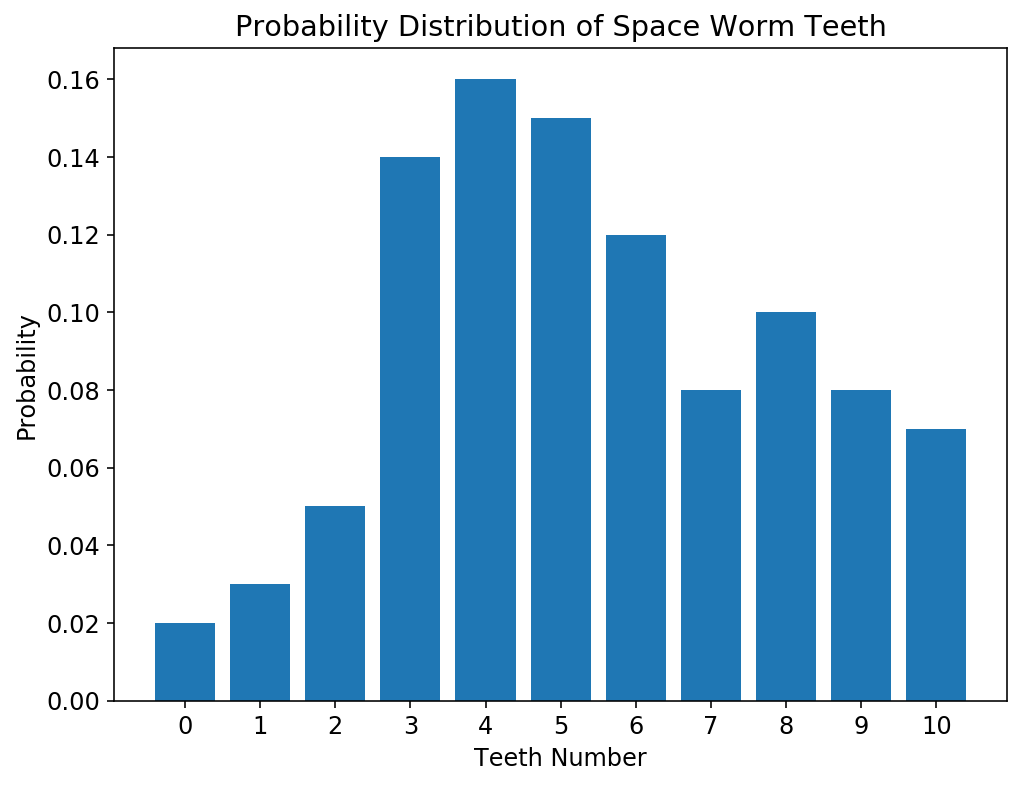

In [3]:
# ensure the probability adds up to 1
true_data = np.array([0.02, 0.03, 0.05, 0.14, 0.16, 0.15, 0.12, 0.08, 0.1, 0.08, 0.07])
n = true_data.shape[0]
index = np.arange(n)
assert sum(true_data) == 1.0

# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

plt.bar(index, true_data)
plt.xlabel('Teeth Number')
plt.title('Probability Distribution of Space Worm Teeth')
plt.ylabel('Probability')
plt.xticks(index)
plt.show()

Now we need to send this information back to earth. But the problem is that sending information from space to earth is expensive. So we wish to represent this information with a minimum amount of information, perhaps just one or two parameters. One option to represent the distribution of teeth in worms is a uniform distribution.

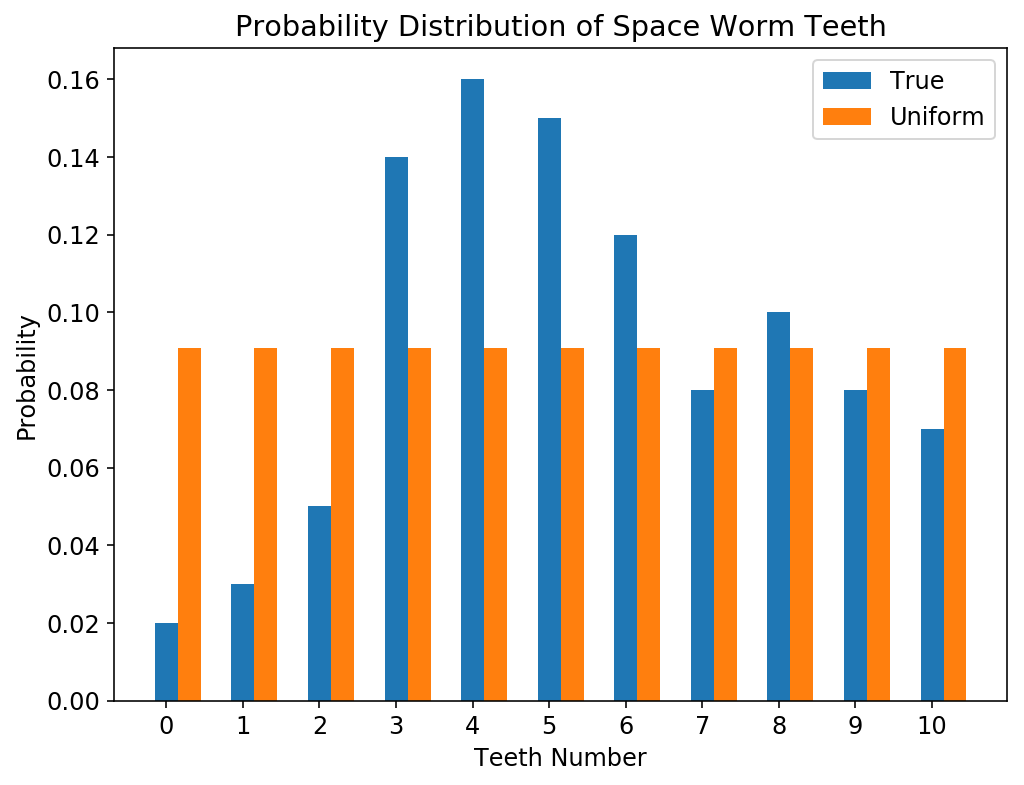

In [4]:
uniform_data = np.full(n, 1.0 / n)

# we can plot our approximated distribution against the original distribution
width = 0.3
plt.bar(index, true_data, width=width, label='True')
plt.bar(index + width, uniform_data, width=width, label='Uniform')
plt.xlabel('Teeth Number')
plt.title('Probability Distribution of Space Worm Teeth')
plt.ylabel('Probability')
plt.xticks(index)
plt.legend()
plt.show()

Another option is to use a binomial distribution.

In [5]:
# we estimate the parameter of the binomial distribution
p = true_data.dot(index) / n
print('p for binomial distribution:', p)
binom_data = binom.pmf(index, n, p)
binom_data

p for binomial distribution: 0.49454545454545457


array([0.00055018, 0.00592134, 0.0289677 , 0.08502751, 0.16638476,
       0.22791121, 0.22299226, 0.15584249, 0.07623949, 0.02486468,
       0.00486561])

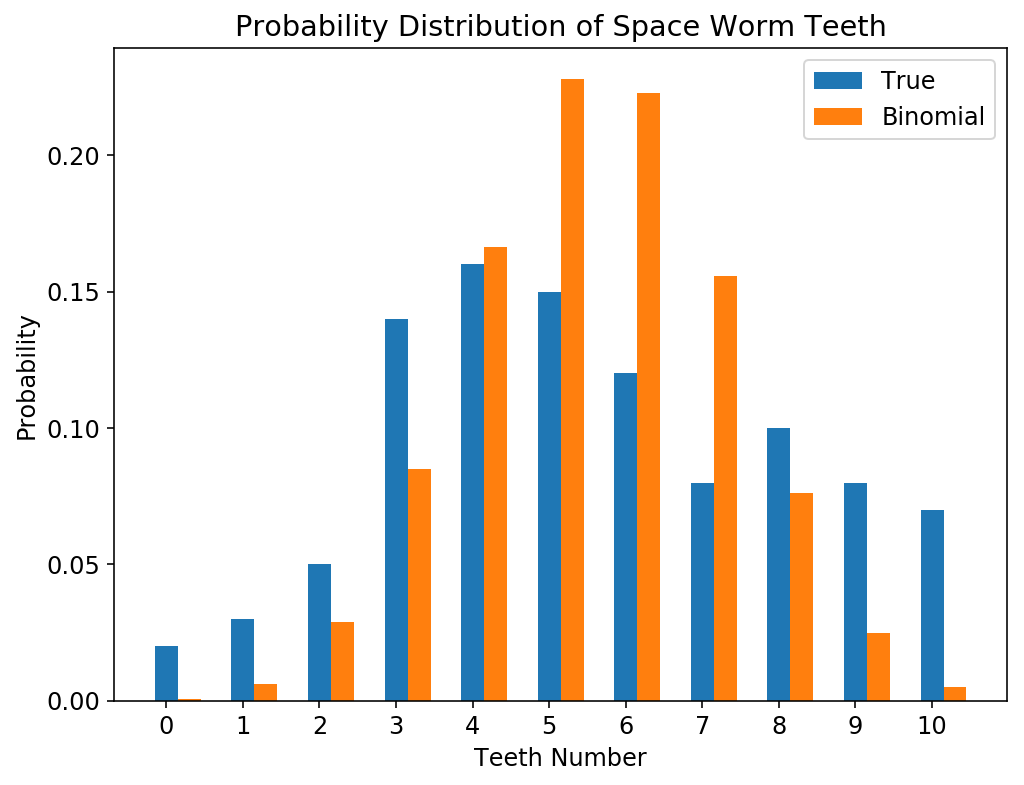

In [6]:
width = 0.3
plt.bar(index, true_data, width=width, label='True')
plt.bar(index + width, binom_data, width=width, label='Binomial')
plt.xlabel('Teeth Number')
plt.title('Probability Distribution of Space Worm Teeth')
plt.ylabel('Probability')
plt.xticks(np.arange(n))
plt.legend()
plt.show()

Comparing each of our models with our original data we can see that neither one is the perfect match, but the question now becomes, which one is better?

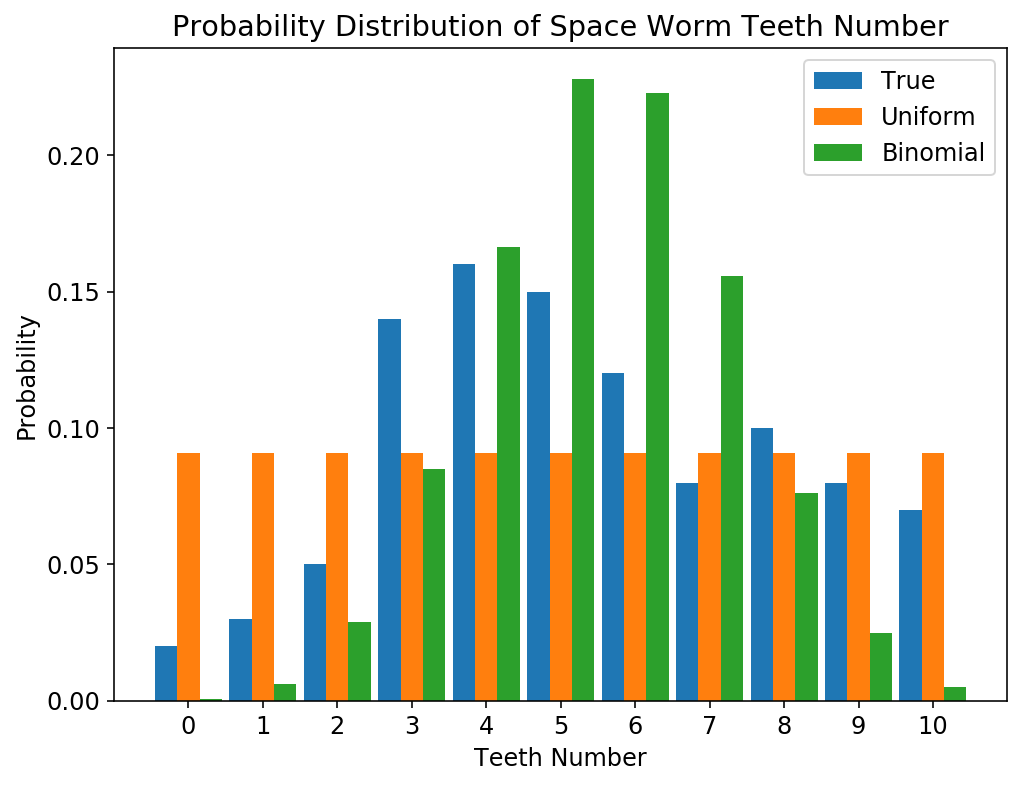

In [7]:
plt.bar(index - width, true_data, width=width, label='True')
plt.bar(index, uniform_data, width=width, label='Uniform')
plt.bar(index + width, binom_data, width=width, label='Binomial')
plt.xlabel('Teeth Number')
plt.title('Probability Distribution of Space Worm Teeth Number')
plt.ylabel('Probability')
plt.xticks(index)
plt.legend()
plt.show()

Given these two distributions that we are using to approximate the original distribution, we need a quantitative way to measure which one does the job better. This is where **Kullback-Leibler (KL) Divergence** comes in.

KL Divergence has its origins in information theory. The primary goal of information theory is to quantify how much information is in our data. To recap, one of the most important metric in information theory is called Entropy, which we will denote as $H$. The entropy for a probability distribution is defined as:

\begin{align}
H = -\sum_{i=1}^N p(x_i) \cdot \log p(x_i)
\end{align}

If we use $log_2$ for our calculation we can interpret entropy as, using a distribution $p$, the minimum number of bits it would take us to encode events drawn from distribution $p$. Knowing we have a way to quantify how much information is in our data, we now extend it to quantify how much information is lost when we substitute our observed distribution for a parameterized approximation.

The formula for Kullback-Leibler Divergence is a slight modification of entropy. Rather than just having our probability distribution $p$ we add in our approximating distribution $q$, then we look at the difference of the log values for each:

\begin{align}
D_{KL}(p || q) = \sum_{i=1}^{N} p(x_i)\cdot (\log p(x_i) - \log q(x_i))
\end{align}

Essentially, what we're looking at with KL divergence is the expectation of the log difference between the probability of data in the original distribution with the approximating distribution. Because we're multiplying the difference between the two distribution with $p(x_i)$, this means that matching areas where the original distribution has a higher probability is more important than areas that has a lower probability. Again, if we think in terms of $\log_2$, we can interpret this as, how many extra bits of information we need to encode events drawn from true distribution $p$, if using an optimal code from distribution $q$ rather than $p$.

The more common way to see KL divergence written is as follows:

\begin{align}
D_{KL}(p || q) = \sum_{i=1}^N p(x_i) \cdot \log \frac{p(x_i)}{q(x_i)}
\end{align}

since $\text{log}a - \text{log}b = \text{log}\frac{a}{b}$.

If two distributions, $p$ and $q$ perfectly match, $D_{KL}(p || q) = 0$, otherwise the lower the KL divergence value, the better we have matched the true distribution with our approximation.

Side Note: If you're interested in having an understanding of the relationship between entropy, cross entropy and KL divergence, the following links are good places to start. Maybe they will clear up some of the hand-wavy explanation of these concepts ... [Youtube: A Short Introduction to Entropy, Cross-Entropy and KL-Divergence](https://www.youtube.com/watch?v=ErfnhcEV1O8) and [StackExchange: Why do we use Kullback-Leibler divergence rather than cross entropy in the t-SNE objective function?](https://stats.stackexchange.com/questions/265966/why-do-we-use-kullback-leibler-divergence-rather-than-cross-entropy-in-the-t-sne/265989)

Given these information, we can go ahead and calculate the KL divergence for our two approximating distributions.

In [8]:
# both function are equivalent ways of computing KL-divergence
# one uses for loop and the other uses vectorization
def compute_kl_divergence(p_probs, q_probs):
    """"KL (p || q)"""
    kl_div = 0.0
    for p, q in zip(p_probs, q_probs):
        kl_div += p * np.log(p / q)

    return kl_div


def compute_kl_divergence(p_probs, q_probs):
    """"KL (p || q)"""
    kl_div = p_probs * np.log(p_probs / q_probs)
    return np.sum(kl_div)


print('KL(True||Uniform): ', compute_kl_divergence(true_data, uniform_data))
print('KL(True||Binomial): ', compute_kl_divergence(true_data, binom_data))

KL(True||Uniform):  0.13667971094966938
KL(True||Binomial):  0.32819435311402045


As we can see the information lost by using the Binomial approximation is greater than using the uniform approximation. If we have to choose one to represent our observations, we're better off sticking with the Uniform approximation.

To close this discussion, we used KL-divergence to calculate which our approximate distribution more closely reflects our true distribution. One caveat to note is that it may be tempting to think of KL-divergence as a way of measuring distance, however, whenever we talk about KL-divergence, we do not categorized it as a distance metric due to the fact that it is asymmetric. In other words, $D_{KL}(p || q) \neq D_{KL}(q || p)$.

# Reference

- [Blog: Kullback-Leibler Divergence Explained](https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained)
- [Youtube: A Short Introduction to Entropy, Cross-Entropy and KL-Divergence](https://www.youtube.com/watch?v=ErfnhcEV1O8)
- [StackExchange: Why do we use Kullback-Leibler divergence rather than cross entropy in the t-SNE objective function?](https://stats.stackexchange.com/questions/265966/why-do-we-use-kullback-leibler-divergence-rather-than-cross-entropy-in-the-t-sne/265989)